In [224]:
from automata.fa.dfa import DFA
from automata.fa.nfa import NFA 


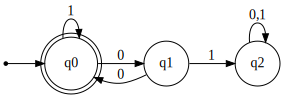

In [225]:
DFA(
    states={"q0", "q1", "q2"},
    input_symbols={"0", "1"},
    transitions={
        "q0": {"0": "q1", "1": "q0"},
        "q1": {"0": "q0", "1": "q2"},
        "q2": {"0": "q2", "1": "q2"},
    },
    initial_state="q0",
    final_states={"q0"},
).show_diagram()

In [226]:
A=DFA(
    states={"q0","q1","q2"},
    input_symbols={"0","1"},
    transitions={
        "q0":{"0":"q1","1":"q2"},
        "q1":{"0":"q0","1":"q2"},
        "q2":{"0":"q2","1":"q2"}
    },
    initial_state="q0",
    final_states={"q0"}
)

B=DFA(
    states={"q0","q1","q2"},
    input_symbols={"0","1"},
    transitions={
        "q0":{"1":"q1","0":"q2"},
        "q1":{"1":"q0","0":"q2"},
        "q2":{"1":"q2","0":"q2"}
    },
    initial_state="q0",
    final_states={"q0"}
)

In [227]:
from automata.fa.dfa import DFA
from automata.fa.nfa import NFA


def q2a() -> str:
    return "01100"


# global, incremented on each fetch
state_id = -1


def find_and_replace(mapping: dict[str, str], s: set[str]) -> set[str]:
    """
    Replaces all existences of keys from `mapping` in `i` with values.
    Return the mutated set, leave the original alone.
    """
    return {mapping.get(val) for val in s}


def get_next_state_id() -> int:
    """
    Returns a unique integer representing a state that exists.
    """
    global state_id
    state_id += 1
    return state_id


def make_state_ids_unique(s: DFA) -> tuple[DFA, dict[str, str]]:
    """
    Replace each state identifier with q{id} where id is a globally unique integer.
    Return the new DFA itself, and the mapping applied.
    """

    # derive a mapping from existing states ids in the dfa to new, unique state ids.
    mapping = {state: f"q{get_next_state_id()}" for state in s.states}

    new_trans = dict()

    # "find and replace" for the dfa's transition functions
    for state, transition in s.transitions.items():
        new_trans[mapping.get(state)] = {
            input_symbol: mapping.get(next_state)
            for input_symbol, next_state in transition.items()
        }

    # "find and replace" over states, initial state, and final states.
    return (
        DFA(
            states=find_and_replace(mapping, s.states),
            input_symbols=s.input_symbols,
            transitions=new_trans,
            initial_state=mapping.get(s.initial_state),
            final_states=find_and_replace(mapping, s.final_states),
        ),
        mapping,
    )


def convert_dfa_trans_to_nfa_trans(
    trans: dict[str, dict[str, str]]
) -> dict[str, dict[str, set]]:
    """
    Since NFA transition functions map symbols to multiple states,
    take each state value in an NFA with a symbol key, and wrap it in a set.
    Return a copy of the transitions array, doesn't mutate the original.
    """

    new_trans: dict[str, dict[str, set]] = dict()

    for state, transition in trans.items():
        new_transition: dict[str, set] = dict()

        for symbol, next_state in transition.items():
            new_transition[symbol] = {next_state}

        new_trans[state] = new_transition

    return new_trans


def q2b(a: DFA, b: DFA) -> NFA:
    """
    The approach:
    1. Transition from all states in a -> b_copy (initial state).
    2. Transition from accept state of b_copy -> a_copy (exit point in a).
    """

    a, _ = make_state_ids_unique(a)
    b, _ = make_state_ids_unique(b)

    all_b_states: set[str] = set()
    all_a_states: set[str] = set()
    all_a_final_states: set[str] = set()

    trans: dict[str, dict[str, set]] = dict()
    trans.update(convert_dfa_trans_to_nfa_trans(a.transitions))

    for a_state in a.states:
        # create unique copy of DFA b and track its transitions and states for the NFA
        b_copy, _ = make_state_ids_unique(b.copy())
        trans.update(convert_dfa_trans_to_nfa_trans(b_copy.transitions))
        all_b_states.update(b_copy.states)

        # epsilon transition from state in a to a complete copy of b
        trans[a_state][""] = {b_copy.initial_state}

        # create unique copy of DFA a and track its transitions and states for the NFA
        a_copy, mapping = make_state_ids_unique(a.copy())
        trans.update(convert_dfa_trans_to_nfa_trans(a_copy.transitions))
        all_a_states.update(a_copy.states)
        all_a_final_states.update(a_copy.final_states)

        # epsilon transition from final state in b to complete copy of a
        b_final_state: str = set(b_copy.final_states).pop()
        re_enter_a_state: str = mapping[a_state]
        trans[b_final_state][""] = {re_enter_a_state}

    return NFA(
        states=set(a.states) | all_b_states | all_a_states,
        input_symbols=set(a.input_symbols) | set(b.input_symbols),
        transitions=trans,
        initial_state=a.initial_state,
        final_states=all_a_final_states,
    )


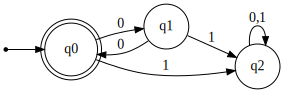

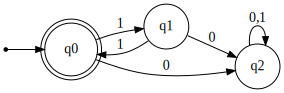

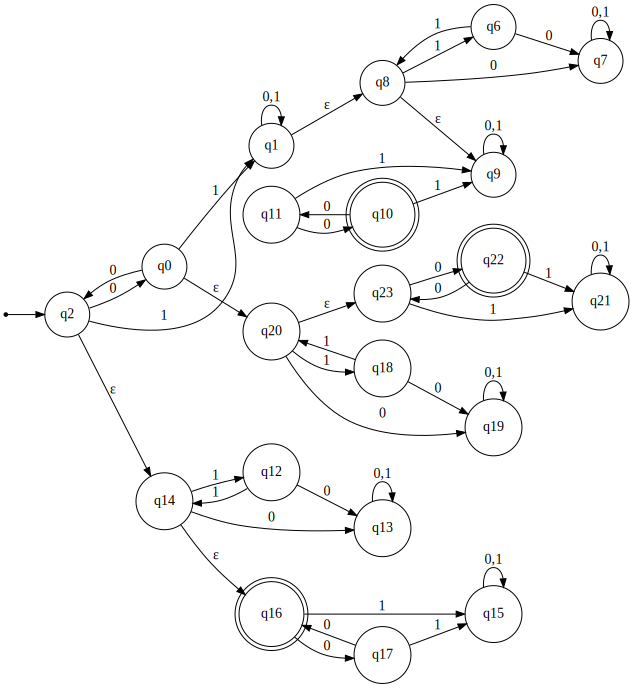

In [228]:
display(A)
display(B)
display(q2b(A, B))